In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
# from sklearnex import patch_sklearn; patch_sklearn() # if you are using intel cpus
import scipy.io as sio
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
import pysindy as ps
from pysindy.utils import lorenz
from tqdm import trange

# NSGA2, DNSGA2, SMSEMOA, AGEMOEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
from okridge.solvel0 import *
from best_subset import backward_refinement, brute_force_all_subsets
from solvel0 import solvel0
from UBIC import *
from kneed import KneeLocator

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

/opt/anaconda3/envs/sindy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sklearn's version: 1.6.1


In [2]:
# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# (x0)' = -9.999 x0 + 9.999 x1
# (x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
# (x2)' = -2.666 x2 + 1.000 x0 x1

max_t = 10; dt = 0.001
t_train = np.arange(0, max_t, dt)
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, (t_train[0], t_train[-1]), 
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)
true_complexities = [2, 3, 2]

In [3]:
noise_level = 1e-2
noise = np.zeros(x_train.shape)
x_train_clean = x_train.copy()
differentiation_method = ps.differentiation.FiniteDifference()

if noise_level > 0:
    # add noise
    noise = np.random.normal(scale=noise_level, size=x_train.shape)
    x_train = x_train_clean + noise
    # denoise
    x_train = savgol_filter(x_train, 23, 3, axis=0)
    # TODO: Implement TVDiff
    differentiation_method = ps.differentiation.SmoothedFiniteDifference()

In [4]:
n_poly = 6
n_ind = len(true_complexities)
n_modules = 8

In [5]:
ode_lib = ps.WeakPDELibrary(function_library=ps.PolynomialLibrary(degree=n_poly, include_bias=False), 
                            spatiotemporal_grid=t_train,
                            include_bias=True,
                            K=5000,
                            differentiation_method=differentiation_method,
                            diff_kwargs={"is_uniform":True})

In [6]:
normalize = False
X_pre = np.array(ode_lib.fit_transform(x_train))
y_pre = np.array(ode_lib.convert_u_dot_integral(x_train))
max_features = np.ones((1, X_pre.shape[-1]))
if normalize:
    max_features = X_pre.max(axis=0)
    X_pre = X_pre / max_features

base_features = dict(zip(distribute_order(n_poly, n_ind), X_pre.T))
# base_features[(0,0,0)] = np.full(base_features[(0,0,0)].shape, base_features[(0,0,0)].mean())

# solvel0(X_pre, y_pre[:, 0:1], miosr=True, refine=True, max_complexity=8)

# from joblib import Parallel, delayed
# res = Parallel(n_jobs=3)(delayed(okridge_solvel0_full)(
#     X_pre, select_column(y_pre, i), k=8) for i in range(3)
#                         )

# GA
# generate (a, b, c) where a, b, c are integers greater than or equal to 0 and a+b+c <= poly_order

In [7]:
class OdeDiscoveryProblem(ElementwiseProblem):
    def __init__(self, n_poly, n_inds, n_modules, 
                 base_features, target, epsilon=1, order_complexity=False):
        super().__init__(n_var=target.shape[-1], n_obj=2, n_ieq_constr=0)
        self.n_poly = n_poly
        self.n_inds = n_ind
        self.n_modules = n_modules
        self.base_features = base_features
        self.target = target
        self.n_target = target.shape[-1]
        self.epsilon = epsilon
        self.order_complexity = order_complexity
        self.sample_size = len(target)

    def _evaluate(self, X, out, *args, **kwargs):
        objective = [0., 0.]
        for v, genome in enumerate(X):
            coeff, mse = self.compute_genome_coefficient(genome, v)
            complexity_penalty = len(genome)
            if self.order_complexity:
                # should we have this additional complexity_penalty
                complexity_penalty += sum(sum(_) for _ in genome)
            complexity_penalty *= self.epsilon
            objective[0] += mse
            objective[1] += complexity_penalty
        out["F"] = objective
        
    def generate_ode_module(self):
        n_poly = self.n_poly
        module = [0 for _ in range(self.n_inds)]
        for i in range(self.n_inds):
            deg = random.randint(0, n_poly)
            module[i] = deg
            n_poly -= deg
            if n_poly <= 0:
                break
        return tuple(module)
        
    def numericalize_genome(self, genome):
        return np.stack([self.base_features[tuple(module)] 
                         for module in genome], axis=-1)

    def compute_genome_coefficient(self, genome, v):
        features = self.numericalize_genome(genome)
        features = features.reshape(-1, features.shape[-1])
        coeff, error, _, _ = np.linalg.lstsq(features, self.target[:, v:v+1])
        mse = error[0]/self.sample_size if len(error) > 0 else np.inf
        return coeff, mse

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

class PopulationSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_target), None, dtype=object)
        for tar in range(problem.n_target):
            X_set = set()
            i = 0
            while i < n_samples:
                n_modules = random.randint(1, problem.n_modules)
                genome = frozenset(problem.generate_ode_module() for _ in range(n_modules))
                if len(genome) > 0 and genome not in X_set:
                    X_set.add(genome)
                    X[i, tar] = genome
                    i += 1
        return X

class DuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, g1, g2):
        n_target = g1.X.shape[-1]
        if n_target != g2.X.shape[-1]:
            return False
        for i in range(n_target):
            if g1.X[i] != g2.X[i]:
                return False
        return True

In [8]:
class GenomeCrossover(Crossover):
    def __init__(self):
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        # The input of has the following shape (n_parents, n_matings, n_target)
        _, n_matings, n_target = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_target)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)
        
        # for each mating provided
        for v in range(n_target):
            for k in range(n_matings):
                # get the first and the second parent
                Y[0, k, v], Y[1, k, v] = self.crossover_permutation(X[0, k, v], X[1, k, v])
                
        return Y
    
    def crossover_permutation(self, genome1, genome2):
        collection = list(genome1) + list(genome2)
        random.shuffle(collection)
        return frozenset(collection[:len(genome1)]), frozenset(collection[len(genome1):])
    
class GenomeMutation(Mutation):
    def __init__(self, add_rate=0.4, del_rate=0.5, order_rate=0.4):
        super().__init__()
        self.add_rate = add_rate
        self.del_rate = del_rate
        self.order_rate = order_rate

    def _do(self, problem, X, **kwargs):
        for v in range(X.shape[1]):
            for i in range(len(X)):
                if random.random() < self.add_rate:
                    X[i, v] = self.add_mutate(problem, X[i, v])
                if random.random() < self.del_rate:
                    X[i, v] = self.del_mutate(problem, X[i, v])
                if random.random() < self.order_rate:
                    X[i, v] = self.module_mutate(problem, X[i, v])
        return X
    
    def add_mutate(self, problem, genome, max_iter=3):
        for _ in range(max_iter):
            new_module = problem.generate_ode_module()
            if new_module not in genome:
                return genome.union(frozenset({new_module}))
        return genome
    
    def del_mutate(self, problem, genome, max_iter=3):
        genome = list(genome)
        lg = len(genome)
        if lg > 0:
            if lg == 1:
                for _ in range(max_iter):
                    new_module = problem.generate_ode_module()
                    if new_module != genome[0]:
                        return frozenset({new_module})
            else:
                genome.pop(random.randint(0, lg-1))
        return frozenset(genome)
    
    def module_mutate(self, problem, genome, max_iter=3):
        if len(genome) == 0:
            return genome
        genome = set(genome)
        genome.remove(random.choice(list(genome)))
        for _ in range(max_iter):
            new_module = problem.generate_ode_module()
            if new_module not in genome:
                genome.add(new_module)
                return frozenset(genome)
        return frozenset(genome)

In [9]:
pop_size = 1000
which_var = 3 # 1, 2, 3
target = y_pre[:, which_var-1:which_var]
problem = OdeDiscoveryProblem(n_poly, n_ind, n_modules, base_features, target, 
                              order_complexity=False)

In [10]:
termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-8,
    period=50,
    n_max_gen=100,
    n_max_evals=200000
)

algorithm = DNSGA2(pop_size=pop_size,
                   sampling=PopulationSampling(),
                   crossover=GenomeCrossover(),
                   mutation=GenomeMutation(),
                   eliminate_duplicates=DuplicateElimination())

res = minimize(problem,
               algorithm,
               termination=termination,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |      7 |             - |             -
     2 |     3100 |      7 |  0.0257340348 |             f
     3 |     5200 |      6 |  0.1428571429 |         nadir
     4 |     7300 |      7 |  0.0237985980 |             f
     5 |     9400 |      7 |  0.3000000000 |         nadir
     6 |    11500 |      7 |  0.0617083965 |             f
     7 |    13600 |     10 |  0.0400000000 |             f
     8 |    15700 |     10 |  0.1111111111 |         nadir
     9 |    17800 |     10 |  3.488007E-11 |             f
    10 |    19900 |     10 |  1.028180E-10 |             f
    11 |    22000 |      9 |  2.257770E-10 |             f
    12 |    24100 |     10 |  0.1000000000 |         nadir
    13 |    26200 |     10 |  4.883488E-12 |             f
    14 |    28300 |     10 |  3.074107E-11 |             f
    15 |    30400 |     11 |  0.2857142857 |         nadir
    16 |    32500 |     12 |  0.0059523810 |            

In [11]:
pareto_optimal_models = res.X

In [12]:
### OPTIONAL ###
from operator import itemgetter

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
effective_candidates = sorted(effective_candidates)

new_pareto_optimal_models = []
for bs in backward_refinement([sorted([effective_candidates.index(_) for _ in list(pm[0])]) for pm in pareto_optimal_models], 
                              (problem.numericalize_genome(effective_candidates), target)).get_best_subsets():
    bs = itemgetter(*bs)(effective_candidates)
    if type(bs[0]) is not tuple:
        bs = (bs,)
    new_pareto_optimal_models.append([frozenset(bs)])
pareto_optimal_models = np.array(new_pareto_optimal_models)
del new_pareto_optimal_models
# pareto_optimal_models

In [13]:
from pymoo.decomposition.asf import ASF
import mcdm

est_complexities = {}
F = problem.evaluate(pareto_optimal_models)
nF = (F - F.min(axis=0))/(F.max(axis=0) - F.min(axis=0))
for weights in np.arange(0.1, 1, 0.1):
    decomp = ASF()
    # est_complexity = int(F[decomp.do(nF, 1/np.array([1-weights, weights])).argmin()][1])
    # est_complexity = mcdm.rank(nF, alt_names=list(map(int, F[:, 1].astype(np.int32))), is_benefit_x=[False, False], 
    #                            n_method=None, w_vector=[1-weights, weights], s_method="mTOPSIS")[0][0]    
    est_complexity = mcdm.rank(F, alt_names=list(map(int, F[:, 1].astype(np.int32))), is_benefit_x=[False, False], 
                               n_method="linear2", w_vector=[1-weights, weights], s_method="mTOPSIS")[0][0]
    if est_complexity not in est_complexities:
        est_complexities[est_complexity] = 1
    else:
        est_complexities[est_complexity] += 1
est_complexities = sorted(est_complexities.items(), key=lambda _: (_[1], -_[0]), reverse=True)

min_ss = min(est_complexities)[0]
max_ss = max(est_complexities)[0]
if max_ss == min_ss:
    max_ss += 1
# epsilon = 10**sci_format(np.median(res.F[:, 0:1]))[1]
# pareto_optimal_models = res.X[np.argsort(res.F[:, 0]+epsilon*res.F[:, 1])]
keep_indices = [i for i in range(len(pareto_optimal_models)) if min_ss <= len(pareto_optimal_models[i][0]) <= max_ss]
pareto_optimal_models = pareto_optimal_models[keep_indices]

est_complexities, pareto_optimal_models

([(2, 9)],
 array([[frozenset({(0, 0, 1), (1, 1, 0)})],
        [frozenset({(0, 2, 0), (0, 0, 1), (1, 1, 0)})]], dtype=object))

In [14]:
significance_threshold = None # 0.95

effective_candidates = frozenset()
for i in range(len(pareto_optimal_models)):
    effective_candidates = effective_candidates.union(pareto_optimal_models[i][0])
    
effective_candidates = {_: 0.0 for _ in effective_candidates}
for i in range(len(pareto_optimal_models)):
    potential_pde = list(pareto_optimal_models[i][0])
    important_scores = shap_linear_importance(problem.numericalize_genome(potential_pde), 
                                              target, scale=True)
    for j in range(len(potential_pde)):
        effective_candidates[potential_pde[j]] += important_scores[j]
        
total_score = sum(effective_candidates.values())
for _ in effective_candidates:
    effective_candidates[_] = effective_candidates[_]/total_score
    
effective_candidates = sorted(effective_candidates.items(), key=lambda _: _[1], reverse=True)
cum_sum = 0
cum_sums = []
top_candidates = []
for i in range(len(effective_candidates)):
    cum_sum += effective_candidates[i][1]
    cum_sums.append(cum_sum)
    top_candidates.append(effective_candidates[i][0])
if significance_threshold is not None:
    top_candidates = top_candidates[:np.argmax((np.array(cum_sums) > significance_threshold).astype(np.int8))+1]
else:
    top_candidates = top_candidates[:knee(range(0, len(cum_sums)), cum_sums, S=1, direction='increasing')+1]

if len(top_candidates) > max_ss:
    top_candidates = np.array(top_candidates)[np.nonzero(linear_model.ARDRegression(max_iter=500, fit_intercept=False).fit(problem.numericalize_genome(top_candidates), target.ravel()).coef_)[0]]
X_pre_top = problem.numericalize_genome(top_candidates)

top_candidates

[(1, 1, 0), (0, 0, 1), (0, 2, 0)]

In [15]:
best_subsets = solvel0(X_pre_top, target, miosr=True, refine=True)

best_subsets = [tuple(best_subsets[-1][_] for _ in bs) 
                for bs in brute_force_all_subsets(X_pre_top[:, best_subsets[-1]], target)[1]]

  0%|                                                                                                | 0/3 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-17


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 581.84it/s]


In [16]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(target))
per = 75 # 80

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre_top, target), 
                                               u_type='cv1', take_sqrt=True, 
                                               ridge_lambda=0, 
                                               threshold=0)
# b_uns = ard_uns # USE ard_uns INSTEAD
predictions = X_pre_top@post_means
print(b_bics)
print(b_uns)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    thres = math.ceil(sci_format(thres)[0])*10**sci_format(thres)[1]
except IndexError:
    thres = 1/40
min_thres = 1/40
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], target))-np.log(len(target))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(target), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(target), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    if last_bc not in bc_seq:
        bc_seq.append(last_bc)

# best_bc = knee_finder(last_ubic)
best_bc = knee(range(len(last_ubic)), last_ubic, 0.95, 'linear')
if best_bc == 0 and last_bc != 0 and abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
    best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 0.95, 'linear')
if best_bc is None:
    print("hmmm")
    best_bc = knee_finder(last_ubic)
#     best_bc = last_bc
#     alt_bc = bc_seq[-2] if len(bc_seq) > 1 else last_bc-1
#     cond = abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres or \
#             abs((b_bics[last_bc]-b_bics[alt_bc])/(b_bics[alt_bc]*(last_bc-alt_bc))) < thres
#     if cond: 
#         best_bc = np.argmin(last_ubic[:alt_bc+1])
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[37764.55378676123, -48914.74029597194, -48984.68958007161]
[1.19701580e+04 1.00000000e+00 2.51428404e+00]
threshold: 2
max_lam: 3.759143253808119
1 <---> 1 inf
1 <---> 1 inf
1 <---> 2 0.001430024644440939


(1.25304775,
 array([1863526.41003731,  -48762.214167  ,  -48601.19556794]),
 1,
 1)

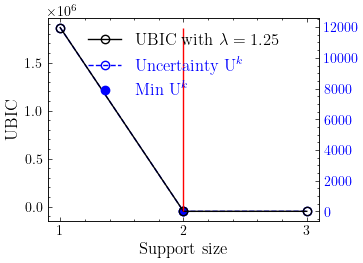

In [17]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), color='red')
    
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=12)
    
    plt.show()